Engineer: Adeola Odunewu
Intern: FlipRobo LLC DS1123
Project: Loan Application Status Classification

In [15]:

import joblib
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.svm import SVC
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message=".*deprecated.*")


In [16]:
# Updated URL with the .zip extension
url = 'https://github.com/FlipRoboTechnologies/ML_-Datasets/raw/main/Temperature%20Forecast/temperature.csv'

# Read the CSV file directly from the URL
df = pd.read_csv(url)

# Display the first few rows of the DataFrame
df.head()

,station,Date,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,30-06-2013,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,30-06-2013,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,30-06-2013,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,30-06-2013,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,30-06-2013,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [3]:
# Count the number of unique values in each column and create a DataFrame with the results
unique_value_counts = df.nunique().to_frame("Unique Values")
print(unique_value_counts)

                  Unique Values
station                      25
Date                        310
Present_Tmax                167
Present_Tmin                155
LDAPS_RHmin                7672
LDAPS_RHmax                7664
LDAPS_Tmax_lapse           7675
LDAPS_Tmin_lapse           7675
LDAPS_WS                   7675
LDAPS_LH                   7675
LDAPS_CC1                  7569
LDAPS_CC2                  7582
LDAPS_CC3                  7599
LDAPS_CC4                  7524
LDAPS_PPT1                 2812
LDAPS_PPT2                 2510
LDAPS_PPT3                 2356
LDAPS_PPT4                 1918
lat                          12
lon                          25
DEM                          25
Slope                        27
Solar radiation            1575
Next_Tmax                   183
Next_Tmin                   157


In [8]:
# Display information about the combined DataFrame, such as column data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7752 entries, 0 to 7751
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7750 non-null   float64
 1   Date              7750 non-null   object 
 2   Present_Tmax      7682 non-null   float64
 3   Present_Tmin      7682 non-null   float64
 4   LDAPS_RHmin       7677 non-null   float64
 5   LDAPS_RHmax       7677 non-null   float64
 6   LDAPS_Tmax_lapse  7677 non-null   float64
 7   LDAPS_Tmin_lapse  7677 non-null   float64
 8   LDAPS_WS          7677 non-null   float64
 9   LDAPS_LH          7677 non-null   float64
 10  LDAPS_CC1         7677 non-null   float64
 11  LDAPS_CC2         7677 non-null   float64
 12  LDAPS_CC3         7677 non-null   float64
 13  LDAPS_CC4         7677 non-null   float64
 14  LDAPS_PPT1        7677 non-null   float64
 15  LDAPS_PPT2        7677 non-null   float64
 16  LDAPS_PPT3        7677 non-null   float64


In [9]:
# Selecting columns with object dtype from the DataFrame and printing them
cate_df = df.select_dtypes(include=['object'])
cate_df.head()

,Date
0,30-06-2013
1,30-06-2013
2,30-06-2013
3,30-06-2013
4,30-06-2013


In [4]:
# Selecting columns with int64 or float64 dtype from the DataFrame and printing them
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df.head()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5


In [11]:
# Generate descriptive statistics for numeric columns
numeric_df.describe()

,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin
count,7750.000000,7682.000000,7682.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,7677.000000,...,7677.000000,7677.000000,7677.000000,7752.000000,7752.000000,7752.000000,7752.000000,7752.000000,7725.000000,7725.000000
mean,13.000000,29.768211,23.225059,56.759372,88.374804,29.613447,23.512589,7.097875,62.505019,0.368774,...,0.485003,0.278200,0.269407,37.544722,126.991397,61.867972,1.257048,5341.502803,30.274887,22.932220
std,7.211568,2.969999,2.413961,14.668111,7.192004,2.947191,2.345347,2.183836,33.730589,0.262458,...,1.762807,1.161809,1.206214,0.050352,0.079435,54.279780,1.370444,429.158867,3.128010,2.487613
min,1.000000,20.000000,11.300000,19.794666,58.936283,17.624954,14.272646,2.882580,-13.603212,0.000000,...,0.000000,0.000000,0.000000,37.456200,126.826000,12.370000,0.098475,4329.520508,17.400000,11.300000
25%,7.000000,27.800000,21.700000,45.963543,84.222862,27.673499,22.089739,5.678705,37.266753,0.146654,...,0.000000,0.000000,0.000000,37.510200,126.937000,28.700000,0.271300,4999.018555,28.200000,21.300000
50%,13.000000,29.900000,23.400000,55.039024,89.793480,29.703426,23.760199,6.547470,56.865482,0.315697,...,0.000000,0.000000,0.000000,37.550700,126.995000,45.716000,0.618000,5436.345215,30.500000,23.100000
75%,19.000000,32.000000,24.900000,67.190056,93.743629,31.710450,25.152909,8.032276,84.223616,0.575489,...,0.018364,0.007896,0.000041,37.577600,127.042000,59.832400,1.767800,5728.316406,32.600000,24.600000
max,25.000000,37.600000,29.900000,98.524734,100.000153,38.542255,29.619342,21.857621,213.414006,0.967277,...,21.621661,15.841235,16.655469,37.645000,127.135000,212.335000,5.178230,5992.895996,38.900000,29.800000


Skewness: -0.26294236931533904


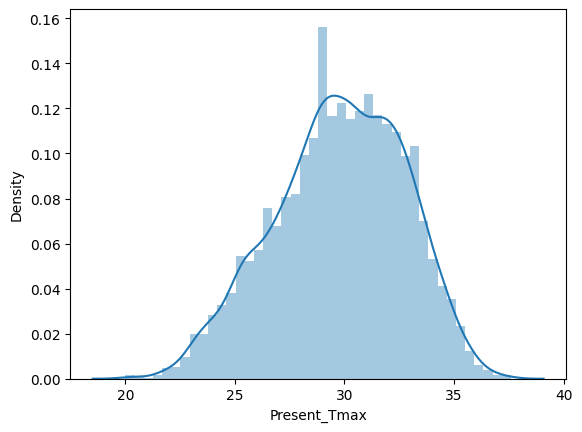

In [18]:
# Engaging in country univariate. Visualizing the frequency distribution of the Present_Tmax using a histogram plot
sns.distplot(numeric_df['Present_Tmax'])
skewness = numeric_df['Present_Tmax'].skew()
print("Skewness:", skewness)
plt.show()


Skewness: -0.36587518142174663


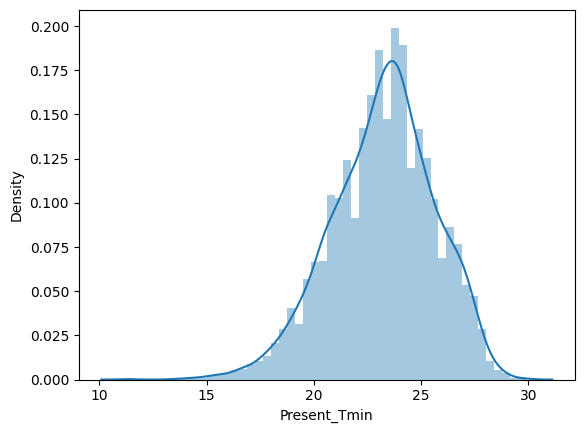

In [17]:
# Engaging in country univariate. Visualizing the frequency distribution of the Present_Tmin using a histogram plot
sns.distplot(numeric_df['Present_Tmin'])
skewness = numeric_df['Present_Tmin'].skew()
print("Skewness:", skewness)
plt.show()

The skewness values (-0.2629 for Present_Tmax and -0.3659 for Present_Tmin) both indicate negative skewness, meaning that the distribution is 
skewed to the left. Since the distributions for both Present_Tmax and Present_Tmin are visually symmetric and have negative skewness values close
to zero, it suggests that the data is relatively symmetrical and balanced, with slightly longer tails on the left side.

Stability in Weather Patterns: For temperature data, a symmetrical distribution with negative skewness suggests that there's some consistency 
or stability in the weather patterns being observed, with a tendency for temperatures to cluster around a central value.

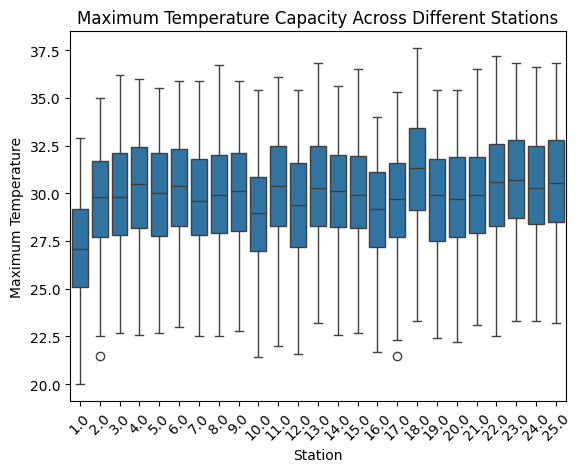

In [19]:
# Create a box plot to visualize the distribution of 'Present_Tmax' across different stations
sns.boxplot(data=numeric_df, x='station', y='Present_Tmax')
plt.title('Maximum Temperature Capacity Across Different Stations')
plt.xlabel('Station')
plt.ylabel('Maximum Temperature')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

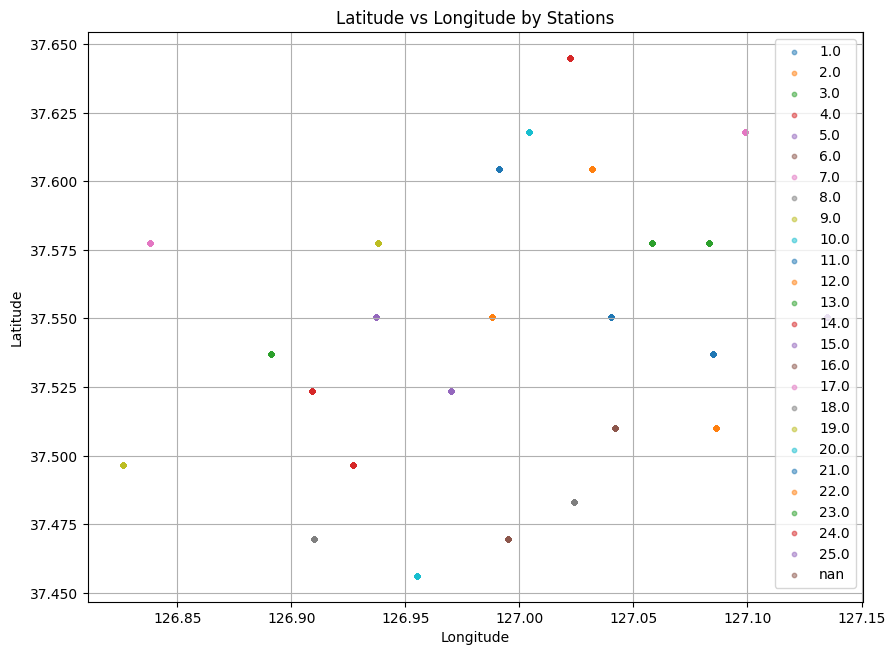

In [26]:
# Set the figure size for better visualization
plt.figure(figsize=(10, 7.4))

# Create a scatter plot of latitude and longitude, color-coded by Stations
for station_code in df['station'].unique():
    station_data = df[df['station'] == station_code]
    plt.scatter(station_data['lon'], station_data['lat'], s=10, alpha=0.5, label=station_code)

# Add title and labels to the plot
plt.title('Latitude vs Longitude by Stations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.legend()

# Add grid lines for better readability
plt.grid(True)

plt.show()


In [27]:
# Handling missing values
missing_data = df.isnull().sum()
print(missing_data)

station              2
Date                 2
Present_Tmax        70
Present_Tmin        70
LDAPS_RHmin         75
LDAPS_RHmax         75
LDAPS_Tmax_lapse    75
LDAPS_Tmin_lapse    75
LDAPS_WS            75
LDAPS_LH            75
LDAPS_CC1           75
LDAPS_CC2           75
LDAPS_CC3           75
LDAPS_CC4           75
LDAPS_PPT1          75
LDAPS_PPT2          75
LDAPS_PPT3          75
LDAPS_PPT4          75
lat                  0
lon                  0
DEM                  0
Slope                0
Solar radiation      0
Next_Tmax           27
Next_Tmin           27
dtype: int64


In [17]:
# Iterate over each column and impute missing values with the median
for column in df.columns:
    if df[column].dtype != object:  # Check if the column contains numeric data
        median_value = df[column].median()  # Calculate the median value of the column
        df[column].fillna(median_value, inplace=True)  # Fill missing values with the median

In [18]:
# Handling missing values
missing_data = df.isnull().sum()
print(missing_data)

station             0
Date                2
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64


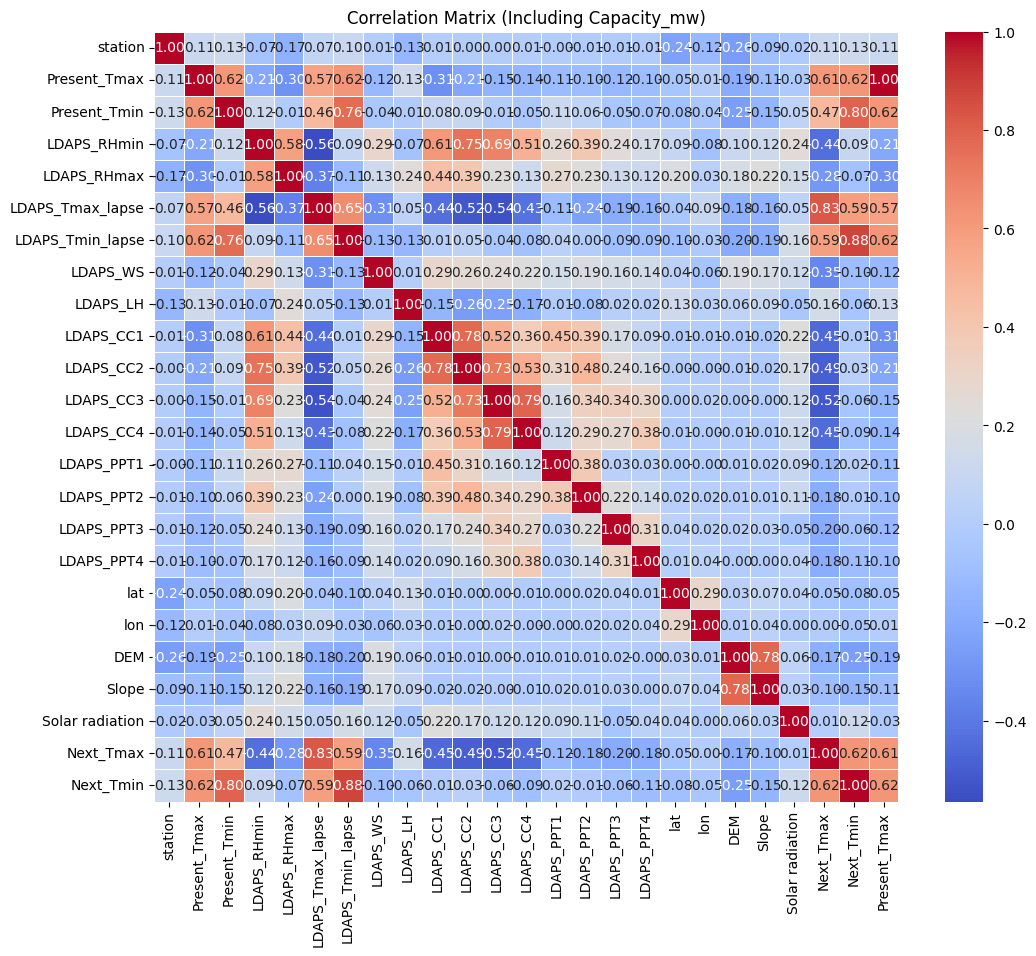

In [19]:
# Reselecting numeric variable
numeric_dataR = df.select_dtypes(include=['int64', 'float64'])

# Correlation Analysis for X is the DataFrame
correlation_matrix = numeric_dataR.corr()

# Calculate correlation coefficients between all predictor variables and the target variable, Present_Tmax
correlation_with_ap = numeric_dataR.corrwith(numeric_dataR['Present_Tmax'])

# Concatenate the correlation coefficients with the original correlation matrix
correlation_matrix_with_ap = pd.concat([correlation_matrix, correlation_with_ap], axis=1)
correlation_matrix_with_ap.columns = list(correlation_matrix.columns) + ['Present_Tmax']

# Plot the correlation matrix including the target variable
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_with_ap, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Including Capacity_mw)")
plt.show()

Present_Tmax (Maximum temperature at present) has a strong positive correlation with Next_Tmax (Maximum temperature in the next time period), 
which makes sense as higher temperatures today might indicate higher temperatures tomorrow.
    
Present_Tmin (Minimum temperature at present) also has a strong positive correlation with Next_Tmin (Minimum temperature in the next time period),
for similar reasons.

In [8]:
import statsmodels.api as sm

# Define the independent variable(s) (X) and the dependent variable (y)
X = numeric_dataR.drop('Present_Tmax', axis=1)  # Include all independent variables except 'capacity_mw'
y = numeric_dataR['Present_Tmax']  # Select the 'capacity_mw' column as the dependent variable

# Add a constant term to the independent variables (for intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Present_Tmax   R-squared:                       0.655
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     637.0
Date:                Thu, 02 May 2024   Prob (F-statistic):               0.00
Time:                        00:23:10   Log-Likelihood:                -15281.
No. Observations:                7752   AIC:                         3.061e+04
Df Residuals:                    7728   BIC:                         3.078e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -120.5148     33.878  

In [35]:
# Define the independent variable(s) (X) and the dependent variable (y)
X = numeric_dataR.drop('Present_Tmin', axis=1)  # Include all independent variables except 'capacity_mw'
y = numeric_dataR['Present_Tmin']  # Select the 'capacity_mw' column as the dependent variable

# Add a constant term to the independent variables (for intercept)
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Present_Tmin   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     829.1
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        14:08:47   Log-Likelihood:                -12976.
No. Observations:                7752   AIC:                         2.600e+04
Df Residuals:                    7728   BIC:                         2.617e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               82.7278     25.167  

The Ordinary Least Squares (OLS) regression model accounts for around 65.5% of the variance in the maximum temperature at present (Present_Tmax) and approximately 71% for the minimum temperature (Present_Tmin).

Several variables including Present_Tmin, LDAPS parameters (e.g., LDAPS_RHmin, LDAPS_RHmax), and geographical features (e.g., lat, lon, DEM) show 
significant associations with Present_Tmax. Notably, LDAPS_LH (Land Data Assimilation System latent heat flux) has a particularly strong positive 
relationship with Present_Tmax. 

However, some variables like LDAPS_PPT1 (LDAPS model forecast precipitation) and Solar radiation do not significantly contribute to the prediction of Present_Tmax. In conclusion, the model suggests that a combination of meteorological and geographical factors can help predict maximum temperatures at present, albeit with some variables showing stronger predictive power than others.

Rows with outliers:
      station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
0         1.0  30-06-2013          28.7          21.4    58.255688   
9        10.0  30-06-2013          31.6          20.5    56.651203   
11       12.0  30-06-2013          31.6          22.2    51.288349   
19       20.0  30-06-2013          30.9          22.2    61.493835   
25        1.0  01-07-2013          28.3          21.2    72.798576   
...       ...         ...           ...           ...          ...   
7742     18.0  30-08-2017          23.3          18.2    30.259682   
7743     19.0  30-08-2017          22.6          15.0    25.536045   
7744     20.0  30-08-2017          22.7          15.9    38.216373   
7750     13.0         NaN          20.0          11.3    19.794666   
7751     13.0         NaN          37.6          29.9    98.524734   

      LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  \
0       91.116364         28.074101         23.006936   6.8

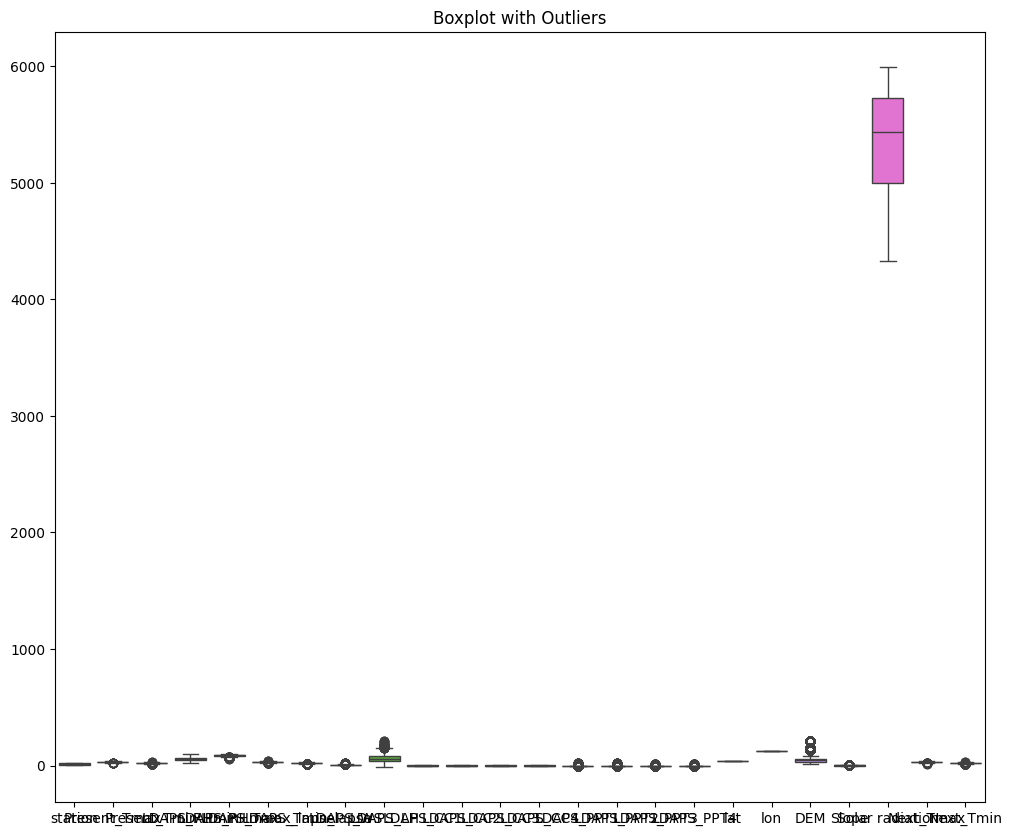

In [36]:
# Identifying Outliers
q1 = numeric_dataR.quantile(0.25)
q3 = numeric_dataR.quantile(0.75)
iqr = q3 - q1

# Define outlier conditions using IQR method
outlier_conditions = ((numeric_dataR < (q1 - 1.5 * iqr)) | (numeric_dataR > (q3 + 1.5 * iqr)))

# Display rows containing outliers
outliers = df[outlier_conditions.any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Visualize the outliers using a boxplot
plt.figure(figsize=(12, 10))  
sns.boxplot(data=numeric_dataR)  # Assuming numeric_dataR contains the columns for visualization
plt.title("Boxplot with Outliers")
plt.show()


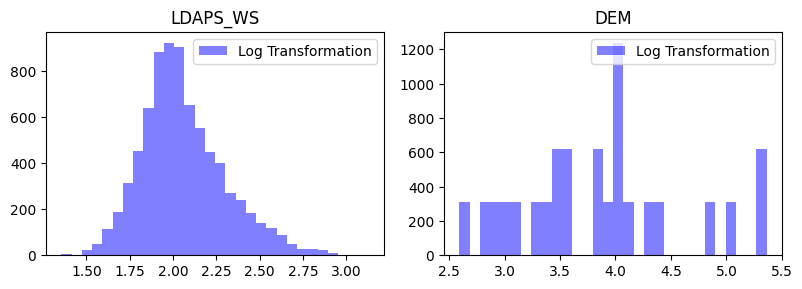

In [4]:
# Handling outliers
# Step 1: Identify Variables with Outliers
outlier_vars = ['LDAPS_WS', 'DEM']

# Step 2: Apply Logarithmic Transformation
# Logarithmic Transformation
log_transformed_vars = df[outlier_vars].apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0) issues

# Replace the original columns with the transformed columns
df[outlier_vars] = log_transformed_vars  

# Visualize the transformed data
plt.figure(figsize=(12, 8))
for i, col in enumerate(outlier_vars):
    plt.subplot(3, 3, i+1)
    plt.hist(log_transformed_vars[col], bins=30, alpha=0.5, color='blue', label='Log Transformation')
    plt.legend()
    plt.title(col)
plt.tight_layout()
plt.show()


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a DataFrame to store VIF values
vif_data = pd.DataFrame()
vif_data["Variable"] = numeric_dataR.columns

# Calculate VIF for each predictor variable
vif_data["VIF"] = [variance_inflation_factor(numeric_dataR.values, i) for i in range(len(numeric_dataR.columns))]

# Print the VIF DataFrame
print(vif_data)

            Variable            VIF
0            station       5.528048
1       Present_Tmax     293.846602
2       Present_Tmin     328.186029
3        LDAPS_RHmin     104.532713
4        LDAPS_RHmax     340.376977
5   LDAPS_Tmax_lapse     893.261389
6   LDAPS_Tmin_lapse     933.569456
7           LDAPS_WS      94.794457
8           LDAPS_LH       6.901043
9          LDAPS_CC1      10.548055
10         LDAPS_CC2      15.304411
11         LDAPS_CC3      13.851579
12         LDAPS_CC4       7.218418
13        LDAPS_PPT1       1.560376
14        LDAPS_PPT2       1.633378
15        LDAPS_PPT3       1.360691
16        LDAPS_PPT4       1.347634
17               lat  672313.264263
18               lon  671572.013114
19               DEM      94.259135
20             Slope       5.374142
21   Solar radiation     193.469214
22         Next_Tmax     456.644546
23         Next_Tmin     578.335721


In [43]:
# PCA Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_dataR)

# Perform PCA
pca = PCA()
pca.fit(scaled_data)

# Transform the data into the principal components
pca_data = pca.transform(scaled_data)

# Extracting explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# df_columns is a list of column names in the df1 DataFrame
df_columns = numeric_dataR.columns.tolist()

# Create a DataFrame to store the variable loadings for each principal component
loadings_df = pd.DataFrame(pca.components_, columns=df_columns)

# Print the variable loadings for each principal component
for i in range(loadings_df.shape[0]):
    print(f"Principal Component {i+1} Loadings:")
    print(loadings_df.iloc[i].sort_values(ascending=False))
    print()
# Create a DataFrame to examine the principal components
pca_df = pd.DataFrame(data=pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Visualize the explained variance ratio
print("Explained Variance Ratio:", explained_variance_ratio)


Principal Component 1 Loadings:
LDAPS_CC2           0.303919
LDAPS_CC3           0.299521
LDAPS_RHmin         0.295989
LDAPS_CC1           0.277034
LDAPS_CC4           0.256813
LDAPS_RHmax         0.209364
LDAPS_PPT2          0.183099
LDAPS_WS            0.172554
LDAPS_PPT3          0.143295
LDAPS_PPT4          0.127637
LDAPS_PPT1          0.126666
DEM                 0.094410
Slope               0.078799
Solar radiation     0.054771
lat                 0.038230
lon                -0.001841
station            -0.049352
LDAPS_LH           -0.053319
Present_Tmin       -0.152736
LDAPS_Tmin_lapse   -0.194700
Next_Tmin          -0.195539
Present_Tmax       -0.249753
Next_Tmax          -0.342374
LDAPS_Tmax_lapse   -0.351673
Name: 0, dtype: float64

Principal Component 2 Loadings:
LDAPS_Tmin_lapse    0.411052
Next_Tmin           0.408051
Present_Tmin        0.406881
LDAPS_CC2           0.261722
Present_Tmax        0.249023
LDAPS_RHmin         0.246844
LDAPS_CC1           0.219808
LDAPS_CC3   

The rationale behind the decision-making process for modeling the independent variables in the predictive model is twofold: addressing outliers and
assessing multicollinearity. Initially, outliers in variables like 'LDAPS_WS' and 'DEM' were mitigated through a logarithmic transformation, aiming to 
normalize their distributions. 

Subsequently, Principal Component Analysis (PCA) was employed to reduce dimensionality and identify key patterns in the
data, while also assessing multicollinearity through Variance Inflation Factor (VIF) analysis. These steps collectively aim to enhance the robustness 
and interpretability of the predictive model by addressing data anomalies and identifying influential predictors.

In [20]:
# Set the random seed for reproducibility
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_RHmin', 'LDAPS_CC1', 'LDAPS_CC4','Solar radiation', 'LDAPS_RHmax', 'LDAPS_PPT2', 'LDAPS_WS', 'LDAPS_PPT3', 'LDAPS_PPT4', 'LDAPS_PPT1', 'DEM', 'Slope', 'station', 'LDAPS_LH', 'Present_Tmin', 'LDAPS_Tmin_lapse', 'Next_Tmin', 'Next_Tmax', 'LDAPS_Tmax_lapse']]  # Features (excluding categorical columns)
y = df['Present_Tmax']  # Target variable

# Standardize features and encode target variable
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features
y_encoded = label_encoder.fit_transform(y)  # Encode the target variable

# Split the dataset into training (80%) and testing (20%) sets using encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=123)

In [21]:
from sklearn.model_selection import KFold
# Set the random seed
np.random.seed(123)

# Initialize regressors
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
logistic_regression = LinearRegression()
support_vector_machine = SVR()
xgboost_regressor = xgb.XGBRegressor()
regressors = [random_forest, gradient_boosting, logistic_regression, xgboost_regressor,  support_vector_machine]

# Define number of folds for k-fold cross-validation
num_folds = 5

# Perform k-fold cross-validation for each regressor
for reg in regressors:
    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    
    # Initialize lists to store evaluation metrics for each fold
    mse_scores = []
    r_squared_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        
        # Train the regressor
        reg.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = reg.predict(X_test)
        
        # Evaluate the regressor
        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)
        
        # Append evaluation metrics to lists
        mse_scores.append(mse)
        r_squared_scores.append(r_squared)
    
    # Calculate average evaluation metrics across folds
    avg_mse = np.mean(mse_scores)
    avg_r_squared = np.mean(r_squared_scores)
    
    # Print the results
    print(f"Regressor: {reg.__class__.__name__}")
    print(f"Average Mean Squared Error: {avg_mse:.4f}")
    print(f"Average R-squared: {avg_r_squared:.4f}")
    print("="*50)

Regressor: RandomForestRegressor
Average Mean Squared Error: 118.3969
Average R-squared: 0.8642
Regressor: GradientBoostingRegressor
Average Mean Squared Error: 220.2890
Average R-squared: 0.7474
Regressor: LinearRegression
Average Mean Squared Error: 304.5240
Average R-squared: 0.6508
Regressor: XGBRegressor
Average Mean Squared Error: 118.7732
Average R-squared: 0.8638
Regressor: SVR
Average Mean Squared Error: 320.7558
Average R-squared: 0.6321


Five regression algorithms were evaluated for predicting 'Present_Tmax'. RandomForestRegressor and XGBRegressor achieved the lowest Mean Squared 
Error of around 118, with R-squared values of approximately 0.864. GradientBoostingRegressor followed with an MSE of 220 and an R-squared of 0.747.
LinearRegression had higher errors and a lower R-squared value, indicating comparatively weaker performance. SVR performed the poorest among the models,
with the highest MSE of 320 and the lowest R-squared value of 0.632.

What's interesting here is how RandomForestRegressor and XGBRegressor consistently perform best, showing the lowest errors and highest accuracy in predicting 'Present_Tmax'. This suggests that using methods like random forests and gradient boosting could be really effective for this task. On the other hand, LinearRegression and SVR didn't do as well, indicating they might not be the best choices for this particular prediction.

In [22]:
# Set the random seed for reproducibility
np.random.seed(123)

# Split the dataset into features (X) and the target variable (y)
X = df[['LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_RHmin', 'LDAPS_CC1', 'LDAPS_CC4', 'LDAPS_RHmax', 'LDAPS_PPT2', 'LDAPS_WS', 'LDAPS_PPT3', 'LDAPS_PPT4', 'LDAPS_PPT1', 'DEM', 'Slope', 'station', 'LDAPS_LH', 'LDAPS_Tmin_lapse', 'Next_Tmin', 'Present_Tmax', 'Next_Tmax', 'LDAPS_Tmax_lapse']]  # Features (excluding categorical columns)
y = df['Present_Tmin']  # Target variable

# Standardize features and encode target variable
scaler = StandardScaler()
label_encoder = LabelEncoder()

X_scaled = scaler.fit_transform(X)  # Fit and transform the scaled features
y_encoded = label_encoder.fit_transform(y)  # Encode the target variable

# Split the dataset into training (80%) and testing (20%) sets using encoded labels
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=123)

# Set the random seed
np.random.seed(123)

# Initialize regressors
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()
logistic_regression = LinearRegression()
support_vector_machine = SVR()
xgboost_regressor = xgb.XGBRegressor()
regressors = [random_forest, gradient_boosting, logistic_regression, xgboost_regressor,  support_vector_machine]

# Define number of folds for k-fold cross-validation
num_folds = 5

# Perform k-fold cross-validation for each regressor
for reg in regressors:
    # Initialize KFold
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=123)
    
    # Initialize lists to store evaluation metrics for each fold
    mse_scores = []
    r_squared_scores = []

    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]
        
        # Train the regressor
        reg.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = reg.predict(X_test)
        
        # Evaluate the regressor
        mse = mean_squared_error(y_test, y_pred)
        r_squared = r2_score(y_test, y_pred)
        
        # Append evaluation metrics to lists
        mse_scores.append(mse)
        r_squared_scores.append(r_squared)
    
    # Calculate average evaluation metrics across folds
    avg_mse = np.mean(mse_scores)
    avg_r_squared = np.mean(r_squared_scores)
    
    # Print the results
    print(f"Regressor: {reg.__class__.__name__}")
    print(f"Average Mean Squared Error: {avg_mse:.4f}")
    print(f"Average R-squared: {avg_r_squared:.4f}")
    print("="*50)

Regressor: RandomForestRegressor
Average Mean Squared Error: 95.1100
Average R-squared: 0.8343
Regressor: GradientBoostingRegressor
Average Mean Squared Error: 131.2873
Average R-squared: 0.7712
Regressor: LinearRegression
Average Mean Squared Error: 169.2977
Average R-squared: 0.7050
Regressor: XGBRegressor
Average Mean Squared Error: 79.9700
Average R-squared: 0.8606
Regressor: SVR
Average Mean Squared Error: 180.8978
Average R-squared: 0.6850


In [25]:
# Performing hyperparameter tuning and k-fold validation using XGBoost.

# Set the random seed
np.random.seed(123)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Initialize XGBRegressor
xgboost_regressor = xgb.XGBRegressor()

# Initialize KFold for cross-validation
k_fold = KFold(n_splits=5, shuffle=True, random_state=123)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgboost_regressor, param_grid=param_grid, cv=k_fold, scoring='neg_mean_squared_error')

# Train and evaluate the regressor with hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best estimator from the grid search
best_regressor = grid_search.best_estimator_

# Make predictions on the test set using the best regressor
y_pred = best_regressor.predict(X_test)

# Evaluate the best regressor
mse = mean_squared_error(y_test, y_pred)
# Calculate the R-squared score using the predicted and actual values
r_squared = r2_score(y_test, y_pred)

# Print the results
print(f"Best Regressor: {best_regressor.__class__.__name__}")
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r_squared:.4f}")

Best Regressor: XGBRegressor
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Mean Squared Error: 105.7418
R-squared: 0.8839


In [26]:
from joblib import dump
# Save the best  model to a file
dump(best_regressor, 'best_Present_TmaxXGBRegressor.joblib')

['best_Present_TmaxXGBRegressor.joblib']

In predicting Present_Tmin, RandomForestRegressor and XGBRegressor were the top performers, with the lowest errors (MSE) around 95 and 80, respectively,
and high accuracy (R-squared) around 0.83 and 0.86. GradientBoostingRegressor followed closely with slightly higher errors (MSE of about 131) and an 
accuracy of 0.77. 

For predicting maximum temperature, the best regressor is XGBRegressor. It was trained with the following hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}. The model achieved a Mean Squared Error (MSE) of 105.7418 and an R-squared value of 0.8839.

However, LinearRegression and SVR didn't do as well, showing higher errors and lower accuracy compared to the others. 
This comparison highlights how different models fare in predicting minimum temperatures compared to maximum temperatures, shedding light
on the unique challenges and factors involved in minimum temperature prediction.